In [8]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import torchmetrics

from torch import nn
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [2]:
class RiceModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))


def train_step(model: nn.Module, loss_function: nn.Module, accuracy_function, optim: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss
        train_acc += accuracy_function(y_pred.argmax(dim=1), y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model: nn.Module, loss_function: nn.Module, accuracy_function, dataloader: torch.utils.data.DataLoader):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            y_pred = model(X)
            test_loss += loss_function(y_pred, y)
            test_acc += accuracy_function(y_pred.argmax(dim=1), y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc


def train_model(
        model: nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_function: nn.Module,
        optim: torch.optim.Optimizer,
        accuracy_function,
        epochs: int = 5
):
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           loss_function=loss_function,
                                           accuracy_function=accuracy_function,
                                           optim=optim,
                                           dataloader=train_dataloader)

        test_loss, test_acc = test_step(model=model,
                                        loss_function=loss_function,
                                        accuracy_function=accuracy_function,
                                        dataloader=test_dataloader)

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}')

    return results

In [3]:
# setting train and test directory
train_dir = 'Rice_Image_Dataset/train'
test_dir = 'Rice_Image_Dataset/test'

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

class_names = train_data.classes

BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)


In [7]:
torch.Tensor(test_data.targets)

tensor([0., 0., 0.,  ..., 4., 4., 4.])

In [13]:
rice_model_0 = RiceModelV0(input_shape=3,
                           output_shape=5,
                           hidden_units=10)
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=rice_model_0.parameters(),
                            lr=0.1)

In [5]:
image, label = next(iter(train_dataloader))
image.shape, label

(torch.Size([128, 3, 64, 64]),
 tensor([3, 4, 4, 2, 1, 1, 2, 0, 3, 4, 0, 1, 0, 3, 4, 4, 3, 4, 3, 4, 2, 1, 4, 0,
         4, 4, 1, 2, 3, 2, 1, 2, 2, 2, 4, 3, 1, 4, 0, 3, 2, 3, 3, 0, 0, 4, 1, 4,
         1, 3, 1, 1, 1, 3, 3, 1, 2, 2, 3, 3, 1, 3, 2, 4, 1, 2, 0, 2, 1, 2, 0, 3,
         4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 2, 4, 0, 0, 4, 4, 1, 2, 1, 1, 0, 4, 2,
         3, 1, 2, 2, 1, 2, 2, 4, 4, 2, 2, 2, 1, 1, 1, 3, 4, 0, 0, 2, 4, 2, 3, 2,
         3, 0, 1, 0, 1, 1, 2, 0]))

In [9]:
rice_model_loaded = RiceModelV0(input_shape=3,
                               output_shape=5,
                               hidden_units=10)
rice_model_loaded.load_state_dict(torch.load('rice_model_0_state_dict.pt'))

<All keys matched successfully>

In [10]:
rice_model_loaded.state_dict()

OrderedDict([('block1.0.weight',
              tensor([[[[-0.1042,  0.0033,  0.0468],
                        [ 0.2068,  0.2375,  0.1497],
                        [ 0.2185,  0.0124,  0.0860]],
              
                       [[-0.1770, -0.0250, -0.0058],
                        [ 0.1354,  0.1731, -0.0375],
                        [-0.0893, -0.0163,  0.1537]],
              
                       [[-0.0416,  0.0517,  0.1082],
                        [ 0.1094, -0.0955, -0.0842],
                        [ 0.1780, -0.1055,  0.0992]]],
              
              
                      [[[ 0.2288,  0.0531,  0.2341],
                        [ 0.2128,  0.1042,  0.0345],
                        [ 0.0324,  0.1180, -0.0688]],
              
                       [[ 0.2562,  0.0728,  0.0921],
                        [ 0.1170,  0.3059,  0.1603],
                        [ 0.2293,  0.1839, -0.0150]],
              
                       [[-0.0051,  0.0419,  0.0047],
                       

Evaluating model...


0it [00:00, ?it/s]

Plotting ConfusionMatrix...


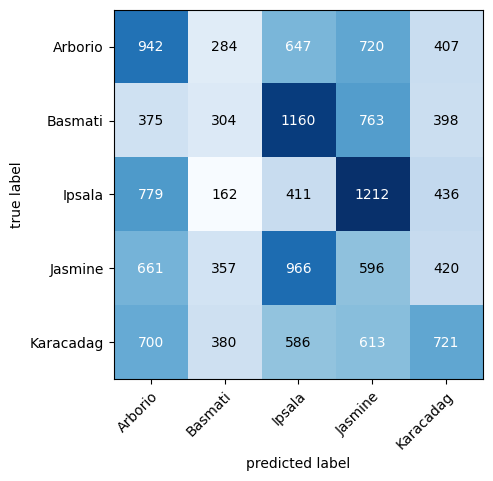

In [11]:
 y_preds = []
rice_model_loaded.eval()
with torch.inference_mode():
    print('Evaluating model...')
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
        y_logit = rice_model_loaded(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred)
y_preds_tensor = torch.cat(y_preds)

print('Plotting ConfusionMatrix...')
cm = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
cm_tensor = cm(preds=y_preds_tensor, target=torch.tensor(test_data.targets))

plot_confusion_matrix(conf_mat=cm_tensor.numpy(), class_names=class_names)
plt.show()


In [ ]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
#             X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

results = eval_model(model=rice_model_loaded,
                    data_loader=test_dataloader,
                    loss_fn=loss_fn,
                    accuracy_fn=acc_fn)

In [ ]:
results